In [674]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import math

from scipy import stats

from tqdm.auto import tqdm
import scipy.linalg as la
import pandas as pd
import scipy.signal as ss 
from time import time
import pandas as pd

plt.rcParams.update({'font.size': 15})


#### Reloads all modules (except those explicitly excluded by %aimport) before executing user code

In [675]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [676]:
#!pip install rpy2

In [677]:
import os
# Using R inside python
import rpy2
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
utils = importr('utils') #-- Only once.
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

In [678]:
rpy2.rinterface_lib.callbacks.consolewrite_warnerror = lambda *args: None


import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
# Defining the R script and loading the instance in Python
# Defining the R script and loading the instance in Python
r = robjects.r
r['source']('methods.R')
# Loading the function we have defined in R.
diff_Inf = robjects.globalenv['diff_Inf']
mSTEM = robjects.globalenv['mSTEM']
not_sic = robjects.globalenv['not_sic']
ts = robjects.globalenv['ts']
tf = robjects.globalenv['tf']
Id = robjects.globalenv['id']
cpop = robjects.globalenv['c_pop']
bup = robjects.globalenv['bup'];

In [679]:
r['source']('simulations.R');
models=robjects.globalenv['models'];
assess=robjects.globalenv['assess'];
finding_dH=robjects.globalenv['finding_dH'];
get_signal = robjects.globalenv['get_signal'];

## Color and marker

In [680]:
from matplotlib.colors import to_rgb

color=['red','#1f77b4' ,'#ff7f0e', '#00ff00', 'green', 'magenta','#808000','cyan','#7f7fff', 'purple']
color=np.array(color)

marker = ['o', '>', 'p', '^', 'v', 's', '<','.', 'D' ,'*'] #['o', 's', 'D', '^', 'v','p']
marker=np.array(marker)

def adjust_color(color, factor=1.2):
    rgb = np.array(to_rgb(color))
    adjusted_rgb = np.clip(rgb * factor, 0, 1)
    return tuple(adjusted_rgb)

# Create an array of slightly darker colors for markerfacecolor
markerfacecolor = np.array([adjust_color(c, 0.5) for c in color])
markeredgecolor=np.array([adjust_color(c, 0.9) for c in color])

 # 3. Section 3 (Recursive approach for change points detection)

In [681]:
from RecMRFTR import RMRFTR

# 6.2 Setting and parameter choice

In [682]:
def degrader_signal(s, para):
    m=len(s)
    sb = np.zeros(m, float)
    noise=np.random.randn(m) # N(0,1)
    noise=(noise-np.mean(noise))/np.std(noise) 
    noise=para[1]*noise+para[0]
    sb = s + noise
    
    return sb

### Setting

In [683]:
models=robjects.globalenv['models']
    
m2=get_signal(models[2-1])  
m4=get_signal(models[4-1])  
m5=get_signal(models[5-1])  
m6=get_signal(models[6-1])  
m7=get_signal(models[7-1])  
m8=get_signal(models[8-1])  


sigma=1
mean=0
y2=degrader_signal(m2, [mean,sigma])
y4=degrader_signal(m4, [mean,sigma])
y5=degrader_signal(m5, [mean,sigma])
y6=degrader_signal(m6, [mean,sigma])
y7=degrader_signal(m7, [mean,sigma])
y8=degrader_signal(m8, [mean,sigma])

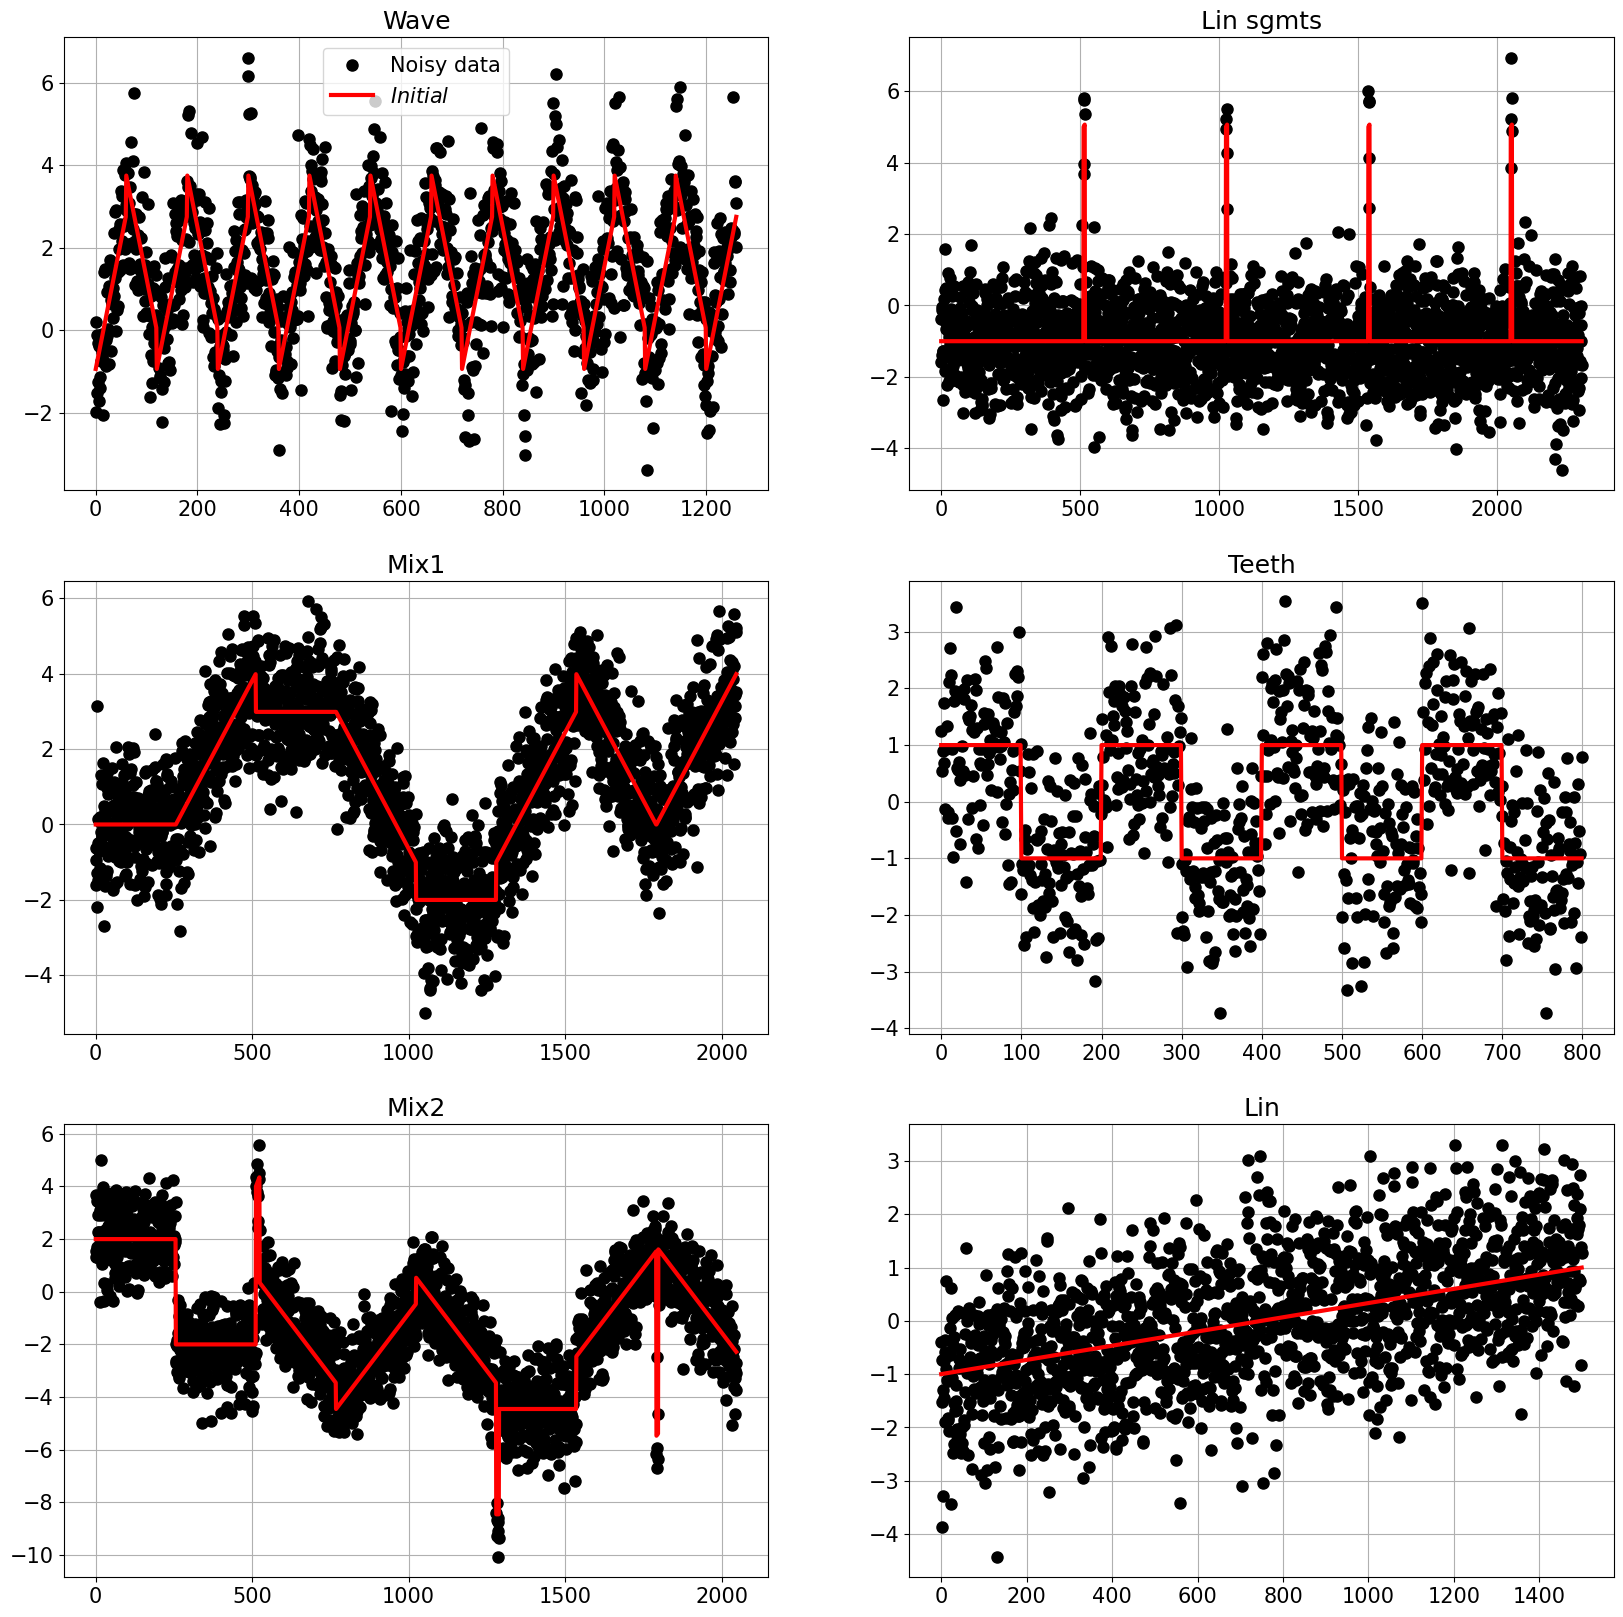

In [684]:
figmodel, ax = plt.subplots(3,2,figsize=(20,20))
# col 1
ax[0,0].plot(y2,'ko',label="Noisy data",markersize=8)
ax[0,0].plot(m2,'r',label=r"$Initial$",lw=3,markersize=4)
ax[0,0].grid()
ax[0,0].set_title("Wave")
#ax[0].set_yticks(np.arange(-2,8,1))
ax[0,0].legend()

ax[1,0].plot(y4,'ko', markersize=8)
ax[1,0].plot(m4,'r', lw=3,markersize=6)
ax[1,0].grid()
ax[1,0].set_title("Mix1")

ax[2,0].plot(y5,'ko', markersize=8)
ax[2,0].plot(m5, 'r', lw=3,markersize=6)
ax[2,0].grid()
ax[2,0].set_title("Mix2")

# col 2
ax[0,1].plot(y6,'ko', markersize=8)
ax[0,1].plot(m6,'r', lw=3,markersize=7)
ax[0,1].grid()
ax[0,1].set_title("Lin sgmts")

ax[1,1].plot(y7,'ko', markersize=8)
ax[1,1].plot(m7,'r', lw=3,markersize=6)
ax[1,1].grid()
ax[1,1].set_title("Teeth")

ax[2,1].plot(y8,'ko', markersize=8)
ax[2,1].plot(m8,'r', lw=3,markersize=6)
ax[2,1].grid()
ax[2,1].set_title("Lin")

plt.show()

### Parameter choice

In [685]:
models=robjects.globalenv['models']
m=5
truex = get_signal(models[m-1]) # sgnl only
true_cpt=models[m-1]
true_cpt=dict(true_cpt.items())
true_cpt=true_cpt['cpt']
exact_nbr_cpts=len(true_cpt)
exact_nbr_cpts

10

In [686]:
set_h0=np.arange(0.5,2.4,0.2)
set_mu=np.arange(20,101 , 10)

In [587]:
Nbr_cpts=[]
n=len(s)
nbr_sim=20
for h0 in tqdm(set_h0,leave=True):
    cpts_h0=[]
    for mu in set_mu:
        #alp = mu * h0**2 / (2**(3/2))
        k=0
        for _ in range(nbr_sim):
            y=degrader_signal(truex, [0,1])
            Rmrftr = RMRFTR(mu=mu,h0=h0)
            Rmrftr.run(y)
            change_points=Rmrftr.ChangePoints
            k+=len(change_points)
        cpts_h0.append(k//nbr_sim)
    Nbr_cpts.append(cpts_h0)

In [ ]:
Nbr_cpts_=[]
for i in range(len( set_mu)):
    a=[]
    for j in range(len(set_h0)):
        a.append(Nbr_cpts[j][i])
    Nbr_cpts_.append(a)

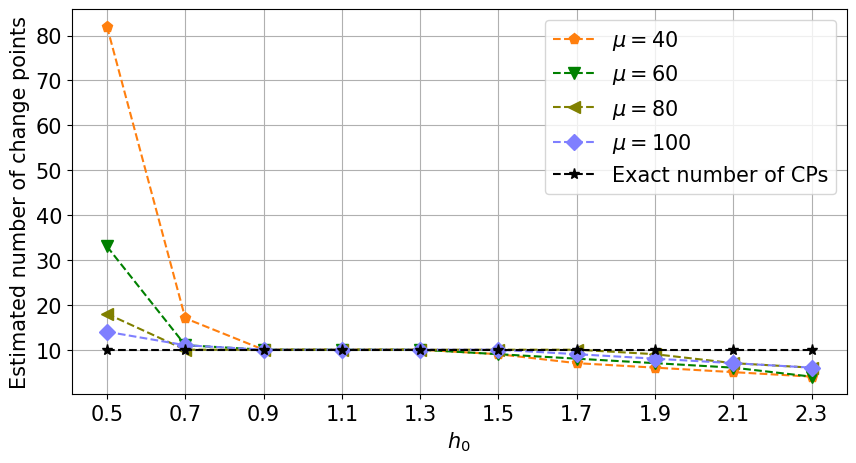

In [652]:
figNbr_cpts, axs = plt.subplots(1,1,figsize=(10,5))

for i, mu in enumerate(set_mu[:]):
    #for j, ls in enumerate(range(20,101,10)):
    name=r"$\mu=$"+str(mu)
    if i in (2,4,6,8):
        axs.plot(set_h0 ,Nbr_cpts_[i] ,label=name, marker=marker[i],color=color[i], markersize=8, linestyle='dashed')
axs.plot(set_h0 ,[exact_nbr_cpts]*len(set_h0) ,label="Exact number of CPs",color='k',marker='*', markersize=8, linestyle='--')

axs.legend()
axs.set(
    xlabel=r'$h_0$',
    ylabel=r'Estimated number of change points')
axs.set_xticks(set_h0)
plt.grid()

### Issue of Binary Segmentation

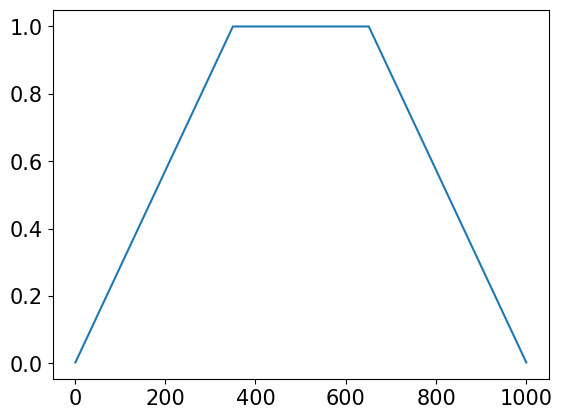

In [502]:
def f(t):
    if t<=350:
        return t/350
    elif t<=650:
        return 1
    else:
        return 1001/350 -t/350 
t=np.arange(1,1001)
ff=np.vectorize(f)
signal=ff(t)
n=len(signal)
plt.plot(t,signal)


### mu=70

In [506]:
Rmrflp = RMRFTR(mu=70,h0=.1,  MAX_nbr_CPs=1)
Rmrflp.run(signal)

Energy=Rmrflp._computeEnergy_dis(signal)
 

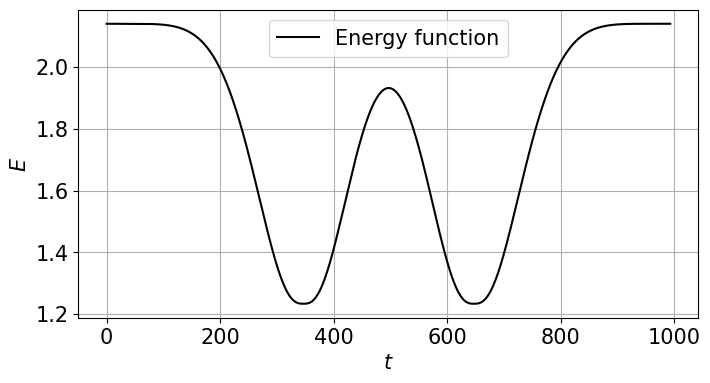

In [517]:
figexenergy, axs = plt.subplots(1,1,figsize=(8,4))
ax=axs
ax.plot(Energy[3:-3], 'k',label='Energy function')

ax.legend()
ax.set(
    xlabel=r'$t$',
    ylabel=r'$E$')
ax.grid()

In [518]:
Rmrflp.restore_withKnownCPs(signal,ChangePoints=[350])
x350=Rmrflp.x_mrf
E350=Energy[350]
E350

1.2339235868963272

In [525]:
Rmrflp.restore_withKnownCPs(signal,ChangePoints=[500])
x500=Rmrflp.x_mrf
E500=Energy[500]
E500

1.9317740933575778

In [520]:
Rmrflp.restore_withKnownCPs(signal,ChangePoints=[650])
x650=Rmrflp.x_mrf
E650=Energy[650]
E650

1.2339235868964271

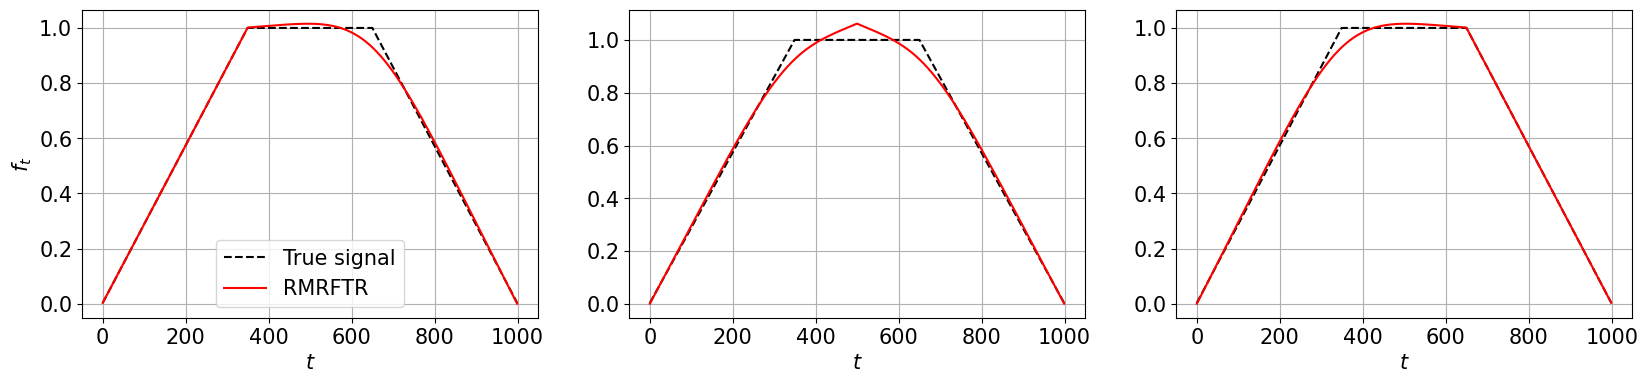

In [521]:
figex, axs = plt.subplots(1,3,figsize=(20,4))
ax=axs[0]
ax.plot(signal,'k--',label='True signal')
ax.plot(x350, 'r',label=r'RMRFTR')

ax.legend()
ax.set(
    xlabel=r'$t$',
    ylabel=r'$f_t$')
ax.grid()

ax=axs[1]
ax.plot(signal,'k--',label='True signal')
ax.plot(x500, 'r',label=r'RMRFTR')
ax.set(xlabel=r'$t$' )
 
ax.grid()

ax=axs[2]
ax.plot(signal,'k--',label='True signal')
ax.plot(x650, 'r',label=r'RMRFTR')
ax.set(xlabel=r'$t$' )

 
ax.grid()

### mu=150

In [527]:
Rmrflp150 = RMRFTR(mu=150,h0=.1,   MAX_nbr_CPs=1)
Rmrflp150.run(signal)
Energy150=Rmrflp150._computeEnergy_dis(signal)

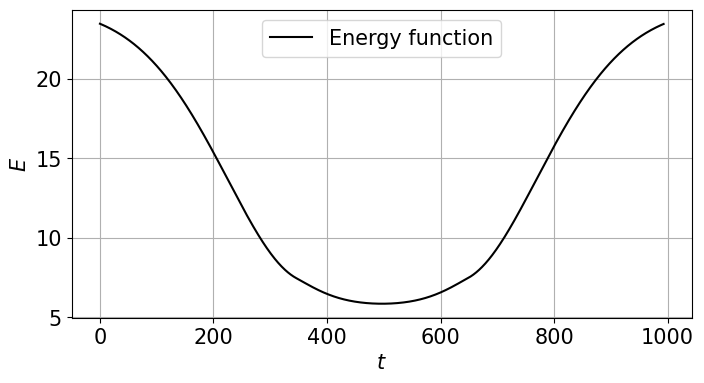

In [528]:
figexenergy150, axs = plt.subplots(1,1,figsize=(8,4))
ax=axs
ax.plot(Energy150[3:-3], 'k',label='Energy function')

ax.legend()
ax.set(
    xlabel=r'$t$',
    ylabel=r'$E$')
ax.grid()

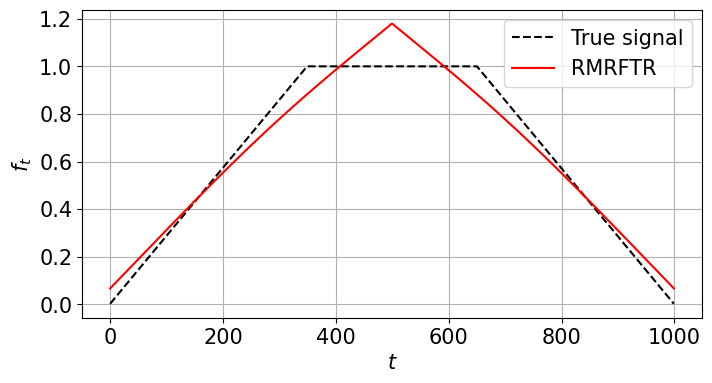

In [529]:
figexmu150, axs = plt.subplots(1,1,figsize=(8,4))
ax=axs
ax.plot(signal,'k--',label='True signal')
ax.plot(Rmrflp150.x_mrf, 'r',label='RMRFTR')

ax.legend()
ax.set(
    xlabel=r'$t$',
    ylabel=r'$f_t$')
ax.grid()

# 6.3 Numerical results

In [692]:
def simulate(N, modelnum, h0,mu, discontinue=True,sigma=1, thr=1.3, p=0.04, bal=0,\
             contrast_NOT="pcwsLinMean",contrast_ID="slope", LambdaID=1,typmSTEM="I",gamma=40, maxerr=300,\
            ord_TF=1, degreeDIF=1):

    models=robjects.globalenv['models']

    truex = get_signal(models[modelnum-1]) # sgnl only
    true_cpt=models[modelnum-1]
    true_cpt=dict(true_cpt.items())
    true_cpt=true_cpt['cpt']
    if modelnum==8:
        true_cpt=[]
    n = len(truex)

    ### Assesement
                              #                      8x10
                              # index col >   0   1  2 3 4 5 6  7  8   9  
                              # row         <=-3 -2 -1 0 1 2 3 MSE dH time
                              # v
    result = np.zeros((10,10))# 1 RMRFTR
                              # 2 TS
                              # 3 NOT
                              # 4 ID
                              # 5 TF
                              # 6 CPOP
                              # 7 BUP
                              # 8 diff_Inf
                              # 9 mSTEM

                        
    for K in range(N):
        y = degrader_signal(truex,[0,sigma])
        # y= truex +np.random.standard_t(5,size=n)*np.sqrt(3/5) # t5-dist with unit variance
        #####################################################################
        ############################## RMRFTR index=1 #######################
        ##################################################################### 
        
        t0=time()
        Rmrftr=RMRFTR(mu=mu,h0=h0, discontinue=discontinue)
        Rmrftr.run(y)
        elapsed=time()-t0
        
        CPS=Rmrftr.ChangePoints
        
        index_method = 1
        qdiff=len(CPS)-len(true_cpt)
        CPS=np.array(CPS)
        dh=finding_dH(CPS,modelnum,models)[0];
        result[index_method,0] += 1 if qdiff <=-3 else 0
        result[index_method,1] += 1 if qdiff ==-2 else 0
        result[index_method,2] += 1 if qdiff ==-1 else 0
        result[index_method,3] += 1 if qdiff == 0 else 0
        result[index_method,4] += 1 if qdiff == 1 else 0
        result[index_method,5] += 1 if qdiff == 2 else 0
        result[index_method,6] += 1 if qdiff >= 3 else 0
        result[index_method,7] += Rmrftr.error(truex)
        result[index_method,8] += dh
        result[index_method,9] += elapsed
        
        #####################################################################
        ################################## TS index=2   #####################
        #####################################################################
        
        obj = ts(y, thr=thr, p=p, bal=bal) ;## cpts is turned "integer(0)" if nothing is detected
        dobj=dict(obj.items())
        aobj = assess(obj=obj, modelnum=modelnum, models=models);
        aobj=dict(aobj.items())
        index_method = 2
        result[index_method,0] += 1 if aobj['qdiff'][0] <=-3 else 0
        result[index_method,1] += 1 if aobj['qdiff'][0] ==-2 else 0
        result[index_method,2] += 1 if aobj['qdiff'][0] ==-1 else 0
        result[index_method,3] += 1 if aobj['qdiff'][0] == 0 else 0
        result[index_method,4] += 1 if aobj['qdiff'][0] == 1 else 0
        result[index_method,5] += 1 if aobj['qdiff'][0] == 2 else 0
        result[index_method,6] += 1 if aobj['qdiff'][0] >= 3 else 0
        result[index_method,7] += aobj['mse']
        result[index_method,8] += aobj['dh']
        result[index_method,9] += dobj['elapsed']
  
        
        #####################################################################
        ################################# NOT index=3   #####################
        #####################################################################
        obj = not_sic(y,contrast=contrast_NOT) ;## cpts is turned "NA" if nothing is detected
        dobj=dict(obj.items())
        aobj = assess(obj=obj, modelnum=modelnum, models=models);
        aobj=dict(aobj.items())
        index_method = 3
        result[index_method,0] += 1 if aobj['qdiff'][0] <=-3 else 0
        result[index_method,1] += 1 if aobj['qdiff'][0] ==-2 else 0
        result[index_method,2] += 1 if aobj['qdiff'][0] ==-1 else 0
        result[index_method,3] += 1 if aobj['qdiff'][0] == 0 else 0
        result[index_method,4] += 1 if aobj['qdiff'][0] == 1 else 0
        result[index_method,5] += 1 if aobj['qdiff'][0] == 2 else 0
        result[index_method,6] += 1 if aobj['qdiff'][0] >= 3 else 0
        result[index_method,7] += aobj['mse']
        result[index_method,8] += aobj['dh']
        result[index_method,9] += dobj['elapsed']
  
        
        #####################################################################
        ################################# ID index=4  #######################
        #####################################################################
        obj = Id(y, Lambda=LambdaID,contrast=contrast_ID); ## cpts is turned "0" if nothing is detected
        dobj=dict(obj.items())
        aobj = assess(obj=obj, modelnum=modelnum, models=models);
        aobj=dict(aobj.items())
        index_method = 4
        result[index_method,0] += 1 if aobj['qdiff'][0] <=-3 else 0
        result[index_method,1] += 1 if aobj['qdiff'][0] ==-2 else 0
        result[index_method,2] += 1 if aobj['qdiff'][0] ==-1 else 0
        result[index_method,3] += 1 if aobj['qdiff'][0] == 0 else 0
        result[index_method,4] += 1 if aobj['qdiff'][0] == 1 else 0
        result[index_method,5] += 1 if aobj['qdiff'][0] == 2 else 0
        result[index_method,6] += 1 if aobj['qdiff'][0] >= 3 else 0
        result[index_method,7] += aobj['mse']
        result[index_method,8] += aobj['dh']
        result[index_method,9] += dobj['elapsed']
  
        #####################################################################
        ########################## Trend Filtering index=5 ##################
        #####################################################################
        obj = tf(y, ord_TF=ord_TF); ## cpts is turned "integer(0)" if nothing is detected
        dobj=dict(obj.items())
        aobj = assess(obj=obj, modelnum=modelnum, models=models);
        aobj=dict(aobj.items())
        index_method = 5
        result[index_method,0] += 1 if aobj['qdiff'][0] <=-3 else 0
        result[index_method,1] += 1 if aobj['qdiff'][0] ==-2 else 0
        result[index_method,2] += 1 if aobj['qdiff'][0] ==-1 else 0
        result[index_method,3] += 1 if aobj['qdiff'][0] == 0 else 0
        result[index_method,4] += 1 if aobj['qdiff'][0] == 1 else 0
        result[index_method,5] += 1 if aobj['qdiff'][0] == 2 else 0
        result[index_method,6] += 1 if aobj['qdiff'][0] >= 3 else 0
        result[index_method,7] += aobj['mse']
        result[index_method,8] += aobj['dh']
        result[index_method,9] += dobj['elapsed']
  
        #####################################################################
        ################################ CPOP index=6 #######################
        #####################################################################
        obj = cpop(y) ;## cpts is turned "numeric(0)" if nothing is detected
        dobj=dict(obj.items())
        aobj = assess(obj=obj, modelnum=modelnum, models=models);
        aobj=dict(aobj.items())
        index_method = 6
        result[index_method,0] += 1 if aobj['qdiff'][0] <=-3 else 0
        result[index_method,1] += 1 if aobj['qdiff'][0] ==-2 else 0
        result[index_method,2] += 1 if aobj['qdiff'][0] ==-1 else 0
        result[index_method,3] += 1 if aobj['qdiff'][0] == 0 else 0
        result[index_method,4] += 1 if aobj['qdiff'][0] == 1 else 0
        result[index_method,5] += 1 if aobj['qdiff'][0] == 2 else 0
        result[index_method,6] += 1 if aobj['qdiff'][0] >= 3 else 0
        result[index_method,7] += aobj['mse']
        result[index_method,8] += aobj['dh']
        result[index_method,9] += dobj['elapsed']
  
        #####################################################################
        ################################# BUP index=7 ######################
        #####################################################################
        obj = bup(y, maxerr); ## cpts is turned "numeric(0)" if nothing is detected
        dobj=dict(obj.items())
        aobj = assess(obj=obj, modelnum=modelnum, models=models);
        aobj=dict(aobj.items())
        index_method = 7
        result[index_method,0] += 1 if aobj['qdiff'][0] <=-3 else 0
        result[index_method,1] += 1 if aobj['qdiff'][0] ==-2 else 0
        result[index_method,2] += 1 if aobj['qdiff'][0] ==-1 else 0
        result[index_method,3] += 1 if aobj['qdiff'][0] == 0 else 0
        result[index_method,4] += 1 if aobj['qdiff'][0] == 1 else 0
        result[index_method,5] += 1 if aobj['qdiff'][0] == 2 else 0
        result[index_method,6] += 1 if aobj['qdiff'][0] >= 3 else 0
        result[index_method,7] += aobj['mse']
        result[index_method,8] += aobj['dh']
        result[index_method,9] += dobj['elapsed']
        #####################################################################
        ################################# Diff_Inf index=8 ##################
        #####################################################################
        obj = diff_Inf(y, degree=degreeDIF); ## cpts is turned "numeric(0)" if nothing is detected
        dobj=dict(obj.items())
        aobj = assess(obj=obj, modelnum=modelnum, models=models);
        aobj=dict(aobj.items())
        index_method = 8
        result[index_method,0] += 1 if aobj['qdiff'][0] <=-3 else 0
        result[index_method,1] += 1 if aobj['qdiff'][0] ==-2 else 0
        result[index_method,2] += 1 if aobj['qdiff'][0] ==-1 else 0
        result[index_method,3] += 1 if aobj['qdiff'][0] == 0 else 0
        result[index_method,4] += 1 if aobj['qdiff'][0] == 1 else 0
        result[index_method,5] += 1 if aobj['qdiff'][0] == 2 else 0
        result[index_method,6] += 1 if aobj['qdiff'][0] >= 3 else 0
        result[index_method,7] += aobj['mse']
        result[index_method,8] += aobj['dh']
        result[index_method,9] += dobj['elapsed'] 
        #####################################################################
        ################################# mSTEM index=9 ##################
        #####################################################################
        obj = mSTEM(y,gamma=gamma, typ=typmSTEM ); ##  II-linear, II-step
        dobj=dict(obj.items())
        aobj = assess(obj=obj, modelnum=modelnum, models=models);
        aobj=dict(aobj.items())
        index_method = 9
        result[index_method,0] += 1 if aobj['qdiff'][0] <=-3 else 0
        result[index_method,1] += 1 if aobj['qdiff'][0] ==-2 else 0
        result[index_method,2] += 1 if aobj['qdiff'][0] ==-1 else 0
        result[index_method,3] += 1 if aobj['qdiff'][0] == 0 else 0
        result[index_method,4] += 1 if aobj['qdiff'][0] == 1 else 0
        result[index_method,5] += 1 if aobj['qdiff'][0] == 2 else 0
        result[index_method,6] += 1 if aobj['qdiff'][0] >= 3 else 0
        result[index_method,7] += aobj['mse']
        result[index_method,8] += aobj['dh']
        result[index_method,9] += dobj['elapsed']
        
    result[:,7]/=N
    result[:,8]/=N
    result[:,9]/=N
    return result

In [693]:
col=("<=-3","-2","-1","0","1","2",">=3","MSE","dh(x10^2)","time")
index=(".","RMRFTR","TS","NOT","ID","TF","CPOP","BUP","DiffInf","mSTEM")

### Results for Mix2

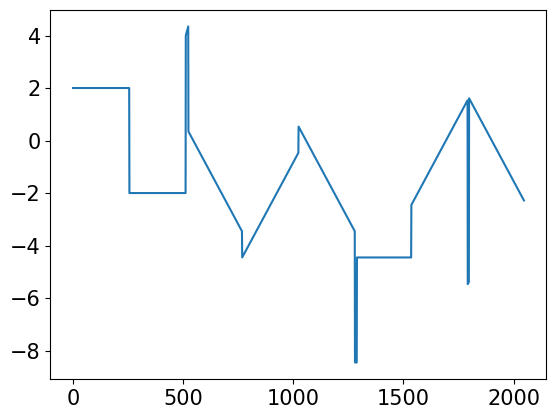

In [694]:
s = get_signal(models[5-1]) 
plt.plot(s,'-')

In [695]:
m5n1=simulate(N=100, modelnum=5, sigma=1, h0=1.7,mu=70, maxerr=350,\
              contrast_ID="slope",LambdaID=1, contrast_NOT="pcwsLinMean",typmSTEM="I", gamma=40,\
             ord_TF=1, degreeDIF=1)

In [605]:
DFm5n1=pd.DataFrame(m5n1,columns=col,index=index)
DFm5n1

,<=-3,-2,-1,0,1,2,>=3,MSE,dh(x10^2),time
.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
RMRFTR,0.0,1.0,6.0,81.0,12.0,0.0,0.0,0.036146,1.108887,4.521543
TS,0.0,0.0,0.0,80.0,20.0,0.0,0.0,0.034700,1.277800,1.017200
NOT,0.0,14.0,7.0,74.0,2.0,1.0,2.0,0.046613,1.020508,0.307180
ID,0.0,0.0,0.0,2.0,8.0,19.0,71.0,0.265406,6.392578,0.146040
TF,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.140157,6.139160,38.892150
CPOP,0.0,0.0,0.0,6.0,24.0,33.0,37.0,0.035691,1.401855,6.615880
BUP,0.0,3.0,16.0,74.0,7.0,0.0,0.0,0.128832,4.494629,3.772110
DiffInf,15.0,40.0,36.0,8.0,1.0,0.0,0.0,0.170553,1.158203,3.822230
mSTEM,45.0,19.0,15.0,12.0,6.0,3.0,0.0,0.514961,6.848633,0.065640


### Results for Teeth


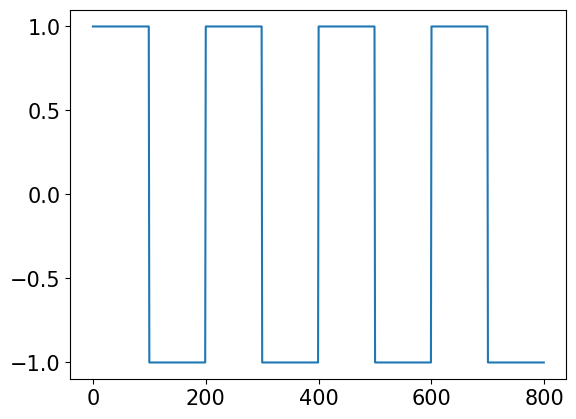

In [611]:
s = get_signal(models[7-1]) 
plt.plot(s,'-')

In [699]:
m7n1 =simulate(N=100, modelnum=7, sigma=1, h0=1,mu=70, maxerr=200,\
              contrast_ID="mean", LambdaID=1, contrast_NOT="pcwsConstMean",typmSTEM="II-step", gamma=30,\
                ord_TF=0, degreeDIF=0)

In [708]:
DFm7n1=pd.DataFrame(m7n1,columns=col,index=index)
DFm7n1

,<=-3,-2,-1,0,1,2,>=3,MSE,dh(x10^2),time
.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.00000
RMRFTR,0.0,0.0,1.0,98.0,1.0,0.0,0.0,0.039000,0.43000,0.94000
TS,0.0,3.0,31.0,40.0,22.0,4.0,0.0,0.110600,6.97120,0.42690
NOT,0.0,0.0,0.0,97.0,3.0,0.0,0.0,0.029834,0.39254,0.12421
ID,0.0,0.0,0.0,96.0,4.0,0.0,0.0,0.031765,0.43158,0.04321
TF,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.095933,6.11000,21.61085
CPOP,0.0,0.0,0.0,3.0,7.0,18.0,72.0,0.054063,3.01875,1.45543
BUP,0.0,2.0,27.0,69.0,2.0,0.0,0.0,0.168000,5.08000,1.31000
DiffInf,1.0,15.0,35.0,47.0,2.0,0.0,0.0,0.133654,7.15500,3.09000
mSTEM,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.089000,0.66000,0.01000


# MSE  by varying $\sigma$

In [718]:
def simulate_error(N, modelnum , h0,mu,discontinue=True, thr=1.3, p=0.04, bal=0,\
             contrast_NOT="pcwsLinMean",contrast_ID="slope", LambdaID=1,typmSTEM="I",gamma=40, maxerr=300,\
            ord_TF=1, degreeDIF=1):
    n = len(truex)
    
    SIGMA=np.arange(0.5,2+0.25,0.25)
    n_obs=N

    Norm_rmrftr=[]
    Norm_not=[]
    Norm_id=[]
    Norm_tr=[]
    Norm_ts=[]
    Norm_tf=[]
    Norm_cpop=[]
    Norm_bup =[]
    Norm_diff =[]
    Norm_mstem =[]
    for sigma in SIGMA:
        norm_rmrftr=0
        norm_tr=0
        norm_not=0
        norm_id=0
        norm_tf=0
        norm_cpop=0
        norm_bup =0
        norm_diff=0
        norm_mstem=0
        for i in range(n_obs):
            b=degrader_signal(np.zeros(n),[0,sigma])
            y=truex+b    
            
            Rmrftr=RMRFTR(mu=mu,h0=h0, discontinue=discontinue)
            Rmrftr.run(y)
            
            TRendsegmentR = dict(ts(y, thr=thr, p=p, bal=bal).items())
            NOt=dict(not_sic(y, contrast=contrast_NOT).items())    
            IDetect=dict(Id(y,contrast=contrast_ID,Lambda=LambdaID).items())
            Tf=dict(tf(y, ord_TF=ord_TF).items())
            Cpop=dict(cpop(y).items()) 
            Bup=dict(bup(y,maxerr).items())
            Diff_Inf=dict(diff_Inf(y, degree=degreeDIF).items())
            MSTEM=dict(mSTEM(y,gamma=gamma, typ=typmSTEM).items()) #II-linear II-step
            
            
            x_tr=TRendsegmentR['fit']
            x_not=NOt['fit']
            x_id=IDetect['fit']
            x_tf=Tf['fit']
            x_cpop=Cpop['fit']
            x_bup=Bup['fit']
            x_diff=Diff_Inf['fit']
            x_mstem=MSTEM['fit']
            
            
            norm_rmrftr  += Rmrftr.error(truex) 
            
            norm_tr   += np.mean((truex-x_tr)**2)
            norm_not  += np.mean((truex-x_not)**2)
            norm_id   += np.mean((truex-x_id)**2)
            norm_tf   += np.mean((truex-x_tf)**2)
            norm_cpop += np.mean((truex-x_cpop)**2)
            norm_bup  += np.mean((truex-x_bup)**2)
            norm_diff +=np.mean((truex-x_diff)**2)
            norm_mstem+=np.mean((truex-x_mstem)**2)
        
        
        norm_rmrftr/=n_obs
        norm_not/=n_obs
        norm_id/=n_obs
        norm_tr/=n_obs
        norm_tf/=n_obs
        norm_cpop/=n_obs
        norm_bup/=n_obs
        norm_diff/=n_obs
        norm_mstem/=n_obs

        Norm_rmrftr.append(norm_rmrftr)
        Norm_tr.append( norm_tr )
        Norm_not.append(norm_not)
        Norm_id.append( norm_id )
        Norm_tf.append( norm_tf )
        Norm_cpop.append(norm_cpop)
        Norm_bup.append( norm_bup )
        Norm_diff.append( norm_diff )
        Norm_mstem.append( norm_mstem )
    methods_res=(Norm_rmrftr, Norm_tr, Norm_not, Norm_id, Norm_tf, Norm_cpop, Norm_bup, Norm_diff, Norm_mstem)
    res=np.zeros((9,len(SIGMA)))
    for i in range(9):
        res[i]=methods_res[i]
    return res


### Results for Mix2

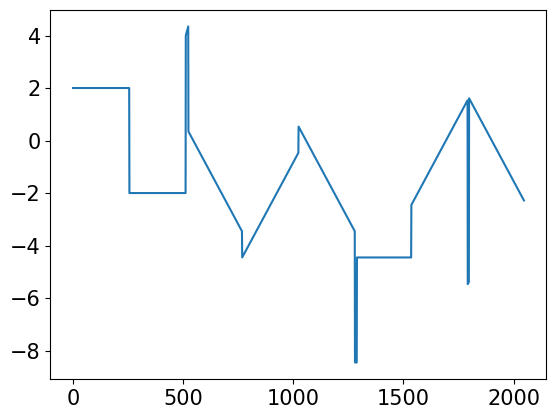

In [714]:
truex = get_signal(models[5-1])
plt.plot(truex)

In [715]:
path='num_res/'
m5n2=np.loadtxt(path+'m5n2.txt')

In [ ]:
m5n2 =simulate_error(N=1, modelnum=5,   h0=1.7, mu=70,  maxerr=350,\
              contrast_ID="slope",LambdaID=1, contrast_NOT="pcwsLinMean",typmSTEM="I", gamma=40,\
             ord_TF=1, degreeDIF=1)

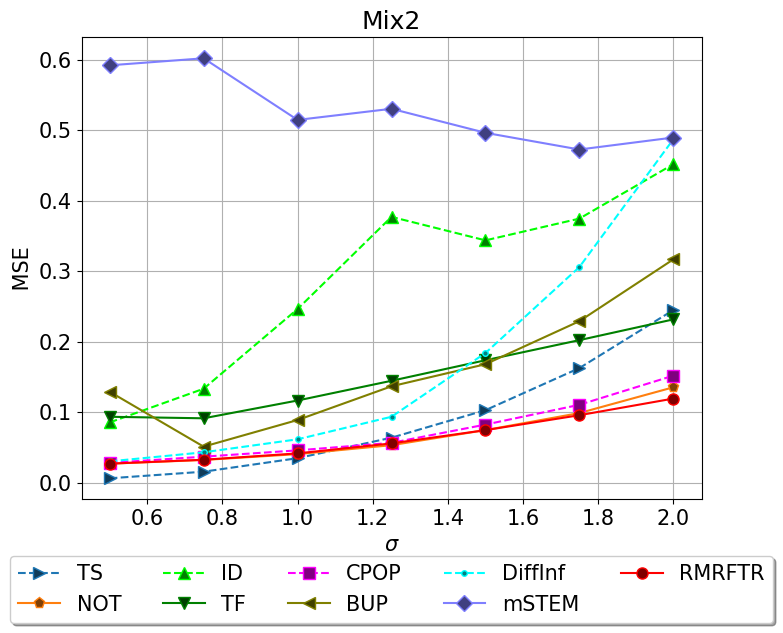

In [720]:
Lab=["RMRFTR", "TS", "NOT", "ID", "TF", "CPOP", "BUP","DiffInf","mSTEM"]
Lab=np.array(Lab)

figAll, ax = plt.subplots(1,1,figsize=(8,6))
SIGMA=np.arange(0.5,2+0.25,0.25)

ax1=ax
indexGood=[1,2,3,4,5,6,7,8,0]
for i in indexGood:
    if i%2==0:
        ax1.plot(SIGMA,m5n2[i],marker=marker[i],color=color[i],label=Lab[i],markersize=8,markerfacecolor=markerfacecolor[i])
    else:
        ax1.plot(SIGMA,m5n2[i],marker=marker[i],color=color[i],label=Lab[i],markersize=8,markerfacecolor=markerfacecolor[i],linestyle='dashed')
# Add labels, title, legend, etc. for the left y-axis
ax1.set_xlabel('$\sigma$')
ax1.set_ylabel(' MSE ')
ax1.set_title('Mix2')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
ax1.grid()
